In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import shapefile as shp

from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen

from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import splot
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


!pip install pyshp

## Pre-processing

### Convert Census Blocks to Census Tracts 

In [5]:
for y in tqdm(range(2002,2003)):
    name='Data/RAC/tx_rac_S000_JT00_'+str(y)+'.csv'
    df=pd.read_csv(name)
    
    # from census blocks too census tracts
    df['h_geocode']=df['h_geocode'].astype(str)
    df['h_geocode_tract'] = df.h_geocode.str.slice(0, 11)
    df=df.groupby(['h_geocode_tract']).sum().reset_index()


    # rename the columns from codes to names
    df=df[['h_geocode_tract','C000','CNS01','CNS02','CNS03','CNS04','CNS05','CNS06','CNS07','CNS08','CNS09','CNS10',
 'CNS11','CNS12','CNS13','CNS14','CNS15','CNS16','CNS17','CNS18','CNS19','CNS20']]
    df.columns=['h_geocode_tract','total','Agriculture; Forestry; Fishing; and Hunting','Mining; Quarrying; and Oil and Gas Extraction',
  'Utilities','Construction','Manufacturing','Wholesale Trade','Retail Trade','Transportation and Warehousing',
 'Information','Finance and Insurance','Real Estate and Rental and Leasing',
  'Professional; Scientific; and Technical Services','Management of Companies and Enterprises','Administrative and Support Services',
  'Educational Services','Health Care and Social Assistance','Arts; Entertainment; and Recreation','Accommodation and Food Services'
  ,'Other Services (Except Public Administration)','Public Administration' ]




100%|██████████| 1/1 [00:09<00:00,  9.39s/it]


### Calculate skill composition


In [16]:
sector=pd.read_csv('Data/sectors_percentage.csv')
sector=sector.fillna(0)
sector[['cognitive','physical']]=sector[['cognitive','physical']]/100

In [17]:
for y in tqdm(range(2002,2003)):
    sector[['cognitive','physical']]=sector[['cognitive','physical']]
    df=df.set_index('h_geocode_tract')
    skills=df[['total']]
    df=df.drop('total',axis=1)
    cog=pd.DataFrame(np.round((df.values* list(sector.cognitive))))
    phys=pd.DataFrame(np.round((df.values* list(sector.physical))))
    cog_tract=cog.sum(min_count=0,skipna=False,axis=1).to_frame()
    phys_tract=phys.sum(min_count=0,skipna=False,axis=1).to_frame()
    skills['h_physical']=phys_tract.values
    skills['h_cognitive']=cog_tract.values
    skills['h_%physical']=skills['h_physical']/skills['total']*100
    skills['h_%cognitive']=skills['h_cognitive']/skills['total']*100
    skills['h_total']=skills['total']




100%|██████████| 1/1 [00:00<00:00, 66.43it/s]


### Merge to our area of study 

In [7]:
locations=pd.read_csv('Data/tx_coords_dallas.csv')

In [19]:
skills=skills.reset_index()


In [20]:
skills.h_geocode_tract=skills.h_geocode_tract.astype(str)
locations.Id=locations.Id.astype(str)

In [21]:
geo_tagged_skills=skills.merge(locations,left_on='h_geocode_tract',right_on='Id')

### Map Zip codes to tracts for housing prices and CBP -- Saud

In [9]:
Home_prices = pd.read_csv('Data/Zip_Zhvi_AllHomes.csv') #1996-01 to 2020-03, 24Years, monthly
Home_prices = Home_prices[Home_prices['State']=='TX']
Home_prices = Home_prices.set_index('RegionName').sort_index()

In [50]:
tracts_zipcode_conversion = pd.read_excel('Data/TRACT_ZIP_062020.xlsx')
tracts_zipcode_conversion = tracts_zipcode_conversion.rename({'ZIP': 'RegionName', 'TRACT':'Id'}, axis=1)

In [51]:
tracts_zipcode_conversion

,Id,RegionName,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,1001020100,36067,1.000000,1.000000,1.000000,1.000000
1,1001020200,36067,1.000000,1.000000,1.000000,1.000000
2,1001020300,36067,1.000000,1.000000,1.000000,1.000000
3,1001020400,36066,0.979601,0.488506,0.945205,0.943742
4,1001020400,36067,0.020399,0.511494,0.054795,0.056258
...,...,...,...,...,...,...
172258,78030960800,802,1.000000,1.000000,1.000000,1.000000
172259,78030960900,802,1.000000,1.000000,1.000000,1.000000
172260,78030961000,802,1.000000,1.000000,1.000000,1.000000
172261,78030961100,802,1.000000,1.000000,1.000000,1.000000


In [42]:
locations

,Id,INTPTLAT10,INTPTLON10
0,48085031624,33.022891,-96.759966
1,48085031630,33.079178,-96.730053
2,48085031623,33.023056,-96.721152
3,48085031625,33.033826,-96.761712
4,48085031708,32.992810,-96.805125
...,...,...,...
1307,48497150200,33.250241,-97.582137
1308,48497150102,33.189591,-97.541048
1309,48497150401,33.310078,-97.820380
1310,48497150402,33.084698,-97.846719


In [46]:
tracts_zipcode_conversion

,TRACT,RegionName,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,1001020100,36067,1.000000,1.000000,1.000000,1.000000
1,1001020200,36067,1.000000,1.000000,1.000000,1.000000
2,1001020300,36067,1.000000,1.000000,1.000000,1.000000
3,1001020400,36066,0.979601,0.488506,0.945205,0.943742
4,1001020400,36067,0.020399,0.511494,0.054795,0.056258
...,...,...,...,...,...,...
172258,78030960800,802,1.000000,1.000000,1.000000,1.000000
172259,78030960900,802,1.000000,1.000000,1.000000,1.000000
172260,78030961000,802,1.000000,1.000000,1.000000,1.000000
172261,78030961100,802,1.000000,1.000000,1.000000,1.000000


In [53]:
# tracts-zipcode conversion only for in and out dallas city
tx_tracts_zipcode_conversion = tracts_zipcode_conversion.merge(locations,on='Id').set_index('RegionName').sort_index()

In [58]:
tx_tracts_zipcode_conversion

,Id,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO,INTPTLAT10,INTPTLON10
RegionName,,,,,,,
75001,48113013726,1.000000,1.000000,1.000000,1.000000,32.944905,-96.848552
75001,48113013727,0.999082,0.930308,0.967146,0.973333,32.966863,-96.838310
75001,48113013725,0.000588,0.170984,0.000000,0.027403,32.962635,-96.846369
75001,48113013616,0.806312,0.521911,0.555755,0.717646,32.955684,-96.824529
75001,48113013806,0.000393,0.082691,0.071895,0.038373,32.934965,-96.837795
...,...,...,...,...,...,...,...
76626,48139061000,0.011858,0.000000,0.000000,0.011208,32.175479,-96.927206
76641,48139061000,0.006588,0.000000,0.000000,0.006227,32.175479,-96.927206
76651,48139061200,0.187273,0.083333,0.333333,0.187391,32.211123,-96.752827


In [59]:
Home_prices

,RegionID,SizeRank,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionName,,,,,,,,,,,,,,,,,,,,,
611,58010,22038,Zip,TX,TX,Silsbee,Beaumont-Port Arthur,Hardin County,NaN,NaN,...,101543.0,101998.0,102147.0,101998.0,102312.0,102533.0,103364.0,103776.0,103802.0,103604.0
715,58059,16188,Zip,TX,TX,Ponce,Midland,Midland County,NaN,NaN,...,167595.0,168348.0,168320.0,167933.0,167605.0,168319.0,168426.0,168640.0,169242.0,170043.0
718,58062,7252,Zip,TX,TX,Newark,Dallas-Fort Worth-Arlington,Wise County,NaN,NaN,...,192908.0,193159.0,193807.0,192736.0,193994.0,196079.0,198590.0,200529.0,199925.0,198361.0
734,58076,34430,Zip,TX,TX,Ponce,Midland,Midland County,NaN,NaN,...,392755.0,393984.0,397104.0,400360.0,401703.0,400910.0,399888.0,398185.0,395905.0,393134.0
775,58097,20114,Zip,TX,TX,Culebra,Stephenville,Erath County,NaN,NaN,...,93739.0,93918.0,94124.0,94441.0,94602.0,94895.0,95634.0,96777.0,97968.0,99292.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79934,93142,4923,Zip,TX,TX,El Paso,El Paso,El Paso County,99187.0,99217.0,...,150664.0,151330.0,151863.0,151913.0,151825.0,151920.0,152657.0,153372.0,153775.0,153805.0
79935,93143,7344,Zip,TX,TX,El Paso,El Paso,El Paso County,88532.0,88447.0,...,150140.0,150620.0,151225.0,150987.0,150734.0,150691.0,151443.0,152248.0,152630.0,152888.0
79936,93144,8,Zip,TX,TX,El Paso,El Paso,El Paso County,82351.0,82307.0,...,132695.0,133092.0,133465.0,133493.0,133533.0,133698.0,134254.0,134898.0,135379.0,135636.0


In [64]:
tract_house_price = tx_tracts_zipcode_conversion.merge(Home_prices,on='RegionName').set_index('Id').sort_index()
tract_house_price = tract_house_price.drop(tract_house_price.columns[[4,5,6,7,8,9,10,11,12,13]], axis=1)
tract_house_price = tract_house_price.fillna(0)

In [67]:
tract_house_price_ = tract_house_price.iloc[:,4:]
tract_house_price_r = tract_house_price.iloc[:,:4]
tract_house_price_r_ = tract_house_price.iloc[:,3]

# aggregating all the tracts ratios 
tract_house_price_.multiply(tract_house_price_r_.values, axis=0)
tract_house_price_ = pd.concat([tract_house_price_r, tract_house_price_], axis =1)
tract_house_price_ = tract_house_price_.groupby('Id').sum()

In [68]:
tract_house_price_y = tract_house_price_.iloc[:,4:].groupby(by=lambda x: x.split('-')[0], axis=1).mean()

In [69]:
tract_house_price_y

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Id,,,,,,,,,,,,,,,,,,,,,
48085030100,681705.750000,721403.416667,718867.416667,796493.750000,825365.416667,819853.083333,813045.083333,837225.000000,983886.750000,1.021286e+06,...,902740.500000,918472.916667,9.765892e+05,1.060643e+06,1.153467e+06,1.277868e+06,1.413994e+06,1.535671e+06,1.608126e+06,1.635627e+06
48085030201,591863.000000,621404.166667,617143.750000,668577.000000,696253.000000,701544.083333,689847.333333,706004.416667,741145.333333,7.681118e+05,...,682298.333333,698952.500000,7.519434e+05,8.184744e+05,8.977139e+05,9.919092e+05,1.072179e+06,1.128490e+06,1.151479e+06,1.158474e+06
48085030202,756546.750000,785205.750000,793636.583333,843281.000000,875696.666667,887615.166667,882929.833333,897668.000000,938197.166667,9.830622e+05,...,912132.750000,936515.833333,1.005183e+06,1.100060e+06,1.215911e+06,1.334209e+06,1.436696e+06,1.501499e+06,1.519586e+06,1.528074e+06
48085030203,396777.083333,412427.000000,408171.916667,442904.416667,465485.583333,470496.500000,469904.500000,477762.416667,504215.833333,5.340341e+05,...,471193.333333,483092.833333,5.163082e+05,5.651119e+05,6.235433e+05,6.817479e+05,7.389278e+05,7.875392e+05,8.057695e+05,8.101123e+05
48085030301,417762.083333,427164.500000,441677.083333,461892.333333,462014.750000,466030.000000,472405.583333,481434.750000,500876.083333,5.216079e+05,...,509592.583333,528513.750000,5.719193e+05,6.289907e+05,6.938467e+05,7.495093e+05,7.882941e+05,8.033633e+05,8.020801e+05,8.050100e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48497150403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.572800e+05,...,288301.166667,291194.750000,3.008953e+05,3.189149e+05,3.379253e+05,3.569578e+05,3.853938e+05,4.327953e+05,4.493768e+05,4.677557e+05
48497150500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020827e+05,...,111823.666667,112870.583333,1.162531e+05,1.228556e+05,1.300263e+05,1.369957e+05,1.425458e+05,1.572261e+05,1.712438e+05,1.749967e+05
48497150601,180233.500000,189044.750000,192049.500000,204649.916667,217546.333333,231597.166667,250791.000000,260575.500000,277477.250000,8.014218e+05,...,885854.833333,895646.333333,9.307881e+05,9.888914e+05,1.048538e+06,1.121020e+06,1.231122e+06,1.376569e+06,1.441170e+06,1.488729e+06


# Establishments 

In [83]:
# Reading number of establishments, yearly resolution

est = pd.DataFrame()
for y in ['96','97','98','99','00','01','02','03','04','05','06','07','08','09']:
    file = pd.read_csv('Data/Establishments/zbp'+y+'totals.txt')
    file.columns = map(str.lower, file.columns)
    file = file.set_index('zip').sort_index()
    file['city'], file['stabbr'] = file['name'].str.split(',', 1).str
    file['stabbr'] = file['stabbr'].str.replace(' ', '')
    file = file[file.stabbr=='TX']['est'].to_frame().rename({'est': y}, axis=1)
    est = pd.concat([est,file],axis=1,join='outer')
    est
for y in ['10','11','12','13','14','15','16','17']:
    file = pd.read_csv('Data/Establishments/zbp'+y+'totals.txt')
    file = file.set_index('zip').sort_index()
    file = file[file.stabbr=='TX']['est'].to_frame().rename({'est': y}, axis=1)
    est  = pd.concat([est,file],axis=1,join='outer')
    est
years = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009',
         '2010','2011','2012','2013','2014','2015','2016','2017']

est.columns=  years

In [84]:
est = est.reset_index().rename({'zip': 'RegionName'}, axis=1).set_index('RegionName').sort_index()

In [85]:
est

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
RegionName,,,,,,,,,,,,,,,,,,,,,
73301,1.0,1.0,1.0,1.0,8.0,7.0,17.0,12.0,22.0,26.0,...,14.0,20.0,17.0,22.0,35.0,23.0,21.0,19.0,17.0,29.0
73344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
73960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,4.0
75000,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75001,91.0,180.0,496.0,1016.0,1195.0,1284.0,1482.0,1447.0,1469.0,1490.0,...,1578.0,1525.0,1504.0,1550.0,1609.0,1640.0,1663.0,1698.0,1681.0,1684.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88559,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88570,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
tract_est = tx_tracts_zipcode_conversion.merge(est,on='RegionName').set_index('Id').sort_index()
tract_est = tract_est.fillna(0)

In [87]:
tract_est_ = tract_est.iloc[:,6:]
tract_est_r = tract_est.iloc[:,:4]
tract_est_r_ = tract_est.iloc[:,3]


# aggregating all the tracts ratios 
tract_est_ = tract_est_.multiply(tract_est_r_.values, axis=0)
tract_est_ = pd.concat([tract_est_r, tract_est_], axis =1)
tract_est_ = tract_est_.groupby('Id').sum()


In [91]:
tx_est = tract_est_.iloc[:,4:]

# Inflation

In [92]:
CPI = pd.read_csv('Data/CPI_US.csv')
CPI.set_index('Year', inplace=True)

In [93]:
CPI.columns = range(1, 13)

In [94]:
s = CPI.stack()
year = s.index.get_level_values(0).values
month = s.index.get_level_values(1).values
s.index = pd.PeriodIndex(year=year, month=month, freq='M')

In [95]:
CPI_d = pd.DataFrame(s)
CPI_d.columns = ['CPI']

In [96]:
CPI_d = CPI_d.iloc[996:,:]

In [97]:
CPI_d

,CPI
1996-01,154.400
1996-02,154.900
1996-03,155.700
1996-04,156.300
1996-05,156.600
...,...
2020-01,257.971
2020-02,258.678
2020-03,258.115
2020-04,256.389


In [98]:
CPI_d_y = CPI_d.iloc[:,:].groupby(by=lambda x: str(x).split('-')[0], axis=0).mean()

In [99]:
CPI_d_y

,CPI
1996,156.850000
1997,160.516667
1998,163.008333
1999,166.575000
2000,172.200000
2001,177.066667
2002,179.875000
2003,183.958333
2004,188.883333
2005,195.291667


In [100]:
Raw_home_prices = tract_house_price_y.replace(np.nan, 0).T

In [101]:
Raw_home_prices

Id,48085030100,48085030201,48085030202,48085030203,48085030301,48085030302,48085030303,48085030304,48085030305,48085030403,...,48497150102,48497150200,48497150300,48497150401,48497150402,48497150403,48497150500,48497150601,48497150602,48497150603
1996,6.817058e+05,5.918630e+05,7.565468e+05,396777.083333,417762.083333,417762.083333,6.353978e+05,422841.583333,6.001867e+05,212556.166667,...,201353.583333,77929.250000,77929.250000,0.000000,0.000000e+00,0.000000,0.000000,1.802335e+05,3.256032e+05,124249.583333
1997,7.214034e+05,6.214042e+05,7.852058e+05,412427.000000,427164.500000,427164.500000,6.482692e+05,437873.583333,6.189084e+05,210395.583333,...,212559.500000,83630.000000,83630.000000,0.000000,0.000000e+00,0.000000,0.000000,1.890448e+05,3.500940e+05,137534.500000
1998,7.188674e+05,6.171438e+05,7.936366e+05,408171.916667,441677.083333,441677.083333,6.795571e+05,457443.083333,6.422924e+05,222114.000000,...,210231.500000,86080.166667,86080.166667,0.000000,0.000000e+00,0.000000,0.000000,1.920495e+05,3.588254e+05,148593.916667
1999,7.964938e+05,6.685770e+05,8.432810e+05,442904.416667,461892.333333,461892.333333,7.054256e+05,473679.916667,6.679744e+05,231745.666667,...,224273.166667,92972.916667,92972.916667,0.000000,0.000000e+00,0.000000,0.000000,2.046499e+05,3.824413e+05,244571.166667
2000,8.253654e+05,6.962530e+05,8.756967e+05,465485.583333,462014.750000,462014.750000,7.125833e+05,475323.166667,6.737745e+05,237260.166667,...,237979.583333,103169.666667,103169.666667,0.000000,0.000000e+00,0.000000,0.000000,2.175463e+05,3.997998e+05,265780.916667
2001,8.198531e+05,7.015441e+05,8.876152e+05,470496.500000,466030.000000,466030.000000,7.245579e+05,482603.666667,6.828762e+05,241954.250000,...,251307.500000,116874.083333,116874.083333,0.000000,0.000000e+00,0.000000,0.000000,2.315972e+05,4.098372e+05,269329.166667
2002,8.130451e+05,6.898473e+05,8.829298e+05,469904.500000,472405.583333,472405.583333,7.279907e+05,482621.916667,6.840264e+05,245368.750000,...,264703.083333,131847.916667,131847.916667,0.000000,0.000000e+00,0.000000,0.000000,2.507910e+05,4.269230e+05,283995.416667
2003,8.372250e+05,7.060044e+05,8.976680e+05,477762.416667,481434.750000,481434.750000,7.448058e+05,490831.333333,6.960858e+05,253974.416667,...,279045.833333,141774.000000,141774.000000,0.000000,0.000000e+00,0.000000,0.000000,2.605755e+05,4.432976e+05,289776.250000
2004,9.838868e+05,7.411453e+05,9.381972e+05,504215.833333,500876.083333,500876.083333,7.703464e+05,508982.750000,7.219201e+05,261363.666667,...,291599.750000,149564.500000,149564.500000,0.000000,0.000000e+00,0.000000,0.000000,2.774772e+05,4.635089e+05,299432.416667
2005,1.021286e+06,7.681118e+05,9.830622e+05,534034.083333,521607.916667,521607.916667,8.022665e+05,535650.833333,7.531434e+05,266615.666667,...,548651.500000,152710.416667,414593.583333,468086.833333,4.818742e+05,257280.000000,102082.666667,8.014218e+05,6.130997e+05,449409.916667


In [102]:
CPI_d_y['CPI_Multiplier'] = CPI_d_y['CPI'].iloc[-1] / CPI_d_y['CPI']

In [103]:
CPI_d_y

,CPI,CPI_Multiplier
1996,156.850000,1.641756
1997,160.516667,1.604253
1998,163.008333,1.579732
1999,166.575000,1.545907
2000,172.200000,1.495409
2001,177.066667,1.454308
2002,179.875000,1.431602
2003,183.958333,1.399825
2004,188.883333,1.363325
2005,195.291667,1.318589


In [104]:
CPI_d_y['CPI_Multiplier'].values

array([1.64175582, 1.60425335, 1.57973151, 1.54590665, 1.49540883,
       1.45430761, 1.43160195, 1.3998246 , 1.36332516, 1.31858878,
       1.27738117, 1.24195683, 1.19606821, 1.20030298, 1.18093513,
       1.14479574, 1.12159041, 1.10539416, 1.08774846, 1.08645962,
       1.07290517, 1.05054601, 1.02549738, 1.007244  , 1.        ])

In [105]:
Adjusted_home_prices = Raw_home_prices.T*CPI_d_y['CPI_Multiplier'].values

In [106]:
Adjusted_home_prices

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Id,,,,,,,,,,,,,,,,,,,,,
48085030100,1.119194e+06,1.157314e+06,1.135618e+06,1.231305e+06,1.234259e+06,1.192319e+06,1.163957e+06,1.171968e+06,1.341358e+06,1.346656e+06,...,1.033453e+06,1.030150e+06,1.079516e+06,1.153713e+06,1.253196e+06,1.371031e+06,1.485465e+06,1.574827e+06,1.619775e+06,1.635627e+06
48085030201,9.716945e+05,9.968897e+05,9.749214e+05,1.033558e+06,1.041183e+06,1.020261e+06,9.875868e+05,9.882823e+05,1.010422e+06,1.012824e+06,...,7.810922e+05,7.839384e+05,8.311939e+05,8.902943e+05,9.753299e+05,1.064225e+06,1.126374e+06,1.157264e+06,1.159820e+06,1.158474e+06
48085030202,1.242065e+06,1.259669e+06,1.253733e+06,1.303634e+06,1.309525e+06,1.290865e+06,1.264004e+06,1.256578e+06,1.279068e+06,1.296255e+06,...,1.044206e+06,1.050387e+06,1.111123e+06,1.196588e+06,1.321038e+06,1.431480e+06,1.509316e+06,1.539783e+06,1.530594e+06,1.528074e+06
48085030203,6.514111e+05,6.616374e+05,6.448020e+05,6.846889e+05,6.960913e+05,6.842466e+05,6.727162e+05,6.687836e+05,6.874101e+05,7.041713e+05,...,5.394201e+05,5.418323e+05,5.707241e+05,6.146996e+05,6.774547e+05,7.314509e+05,7.762777e+05,8.076194e+05,8.116065e+05,8.101123e+05
48085030301,6.858633e+05,6.852801e+05,6.977312e+05,7.140424e+05,6.909009e+05,6.777510e+05,6.762968e+05,6.739242e+05,6.828570e+05,6.877863e+05,...,5.833794e+05,5.927760e+05,6.321963e+05,6.841836e+05,7.538364e+05,8.041524e+05,8.281392e+05,8.238470e+05,8.078904e+05,8.050100e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48497150403,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.392465e+05,...,3.300459e+05,3.266012e+05,3.326079e+05,3.468992e+05,3.671422e+05,3.829818e+05,4.048740e+05,4.438305e+05,4.526320e+05,4.677557e+05
48497150500,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.346051e+05,...,1.280153e+05,1.265946e+05,1.285055e+05,1.336360e+05,1.412684e+05,1.469834e+05,1.497510e+05,1.612349e+05,1.724842e+05,1.749967e+05
48497150601,2.958994e+05,3.032757e+05,3.033866e+05,3.163697e+05,3.253207e+05,3.368135e+05,3.590329e+05,3.647600e+05,3.782917e+05,1.056746e+06,...,1.014123e+06,1.004548e+06,1.028888e+06,1.075665e+06,1.139194e+06,1.202749e+06,1.293350e+06,1.411668e+06,1.451610e+06,1.488729e+06


## Analysis

### Visualize skill distribution

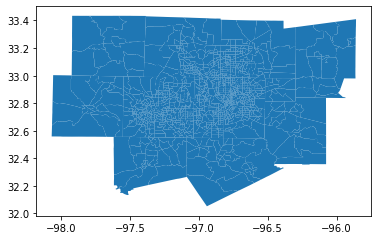

In [22]:

map_df = gpd.read_file('Data/shapefiles/cbsa_trcats_tx.shp')
map_df.GEOID10=map_df.GEOID10.astype(str)


map_df.plot()
plt.grid(b=False)




df = read_shapefile(shapefile)
df.shape
len(df)

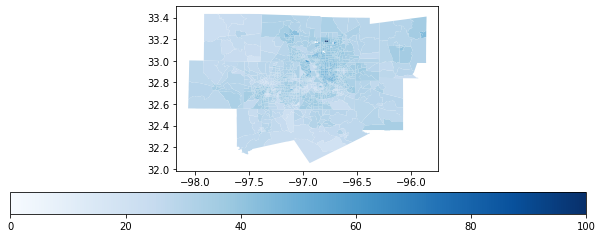

In [23]:
scaler = MinMaxScaler()
geo_tagged_skills['no_skill_c'] = scaler.fit_transform(geo_tagged_skills['h_%cognitive'].values.reshape(-1,1))


merged=map_df.merge(geo_tagged_skills,left_on='GEOID10',right_on='h_geocode_tract')
merged['no_skill_c']=merged['no_skill_c'].replace(0,merged['no_skill_c'].mean())
merged['no_skill_c']=merged['no_skill_c'].fillna(merged['no_skill_c'].mean())
merged=merged.drop_duplicates('GEOID10')


fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(bottom=0.5)
ax.grid(False)


cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=100)



merged.plot(column='no_skill_c', cmap=cmap,ax=ax,linewidth=0.8, edgecolor='none')


cax = plt.axes([0.1, 0.4, 0.8, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
     cax=cax, orientation='horizontal')

plt.show()



### Calculate Spatial Autocorrelation

Global moran's I: 0.5456723273985968


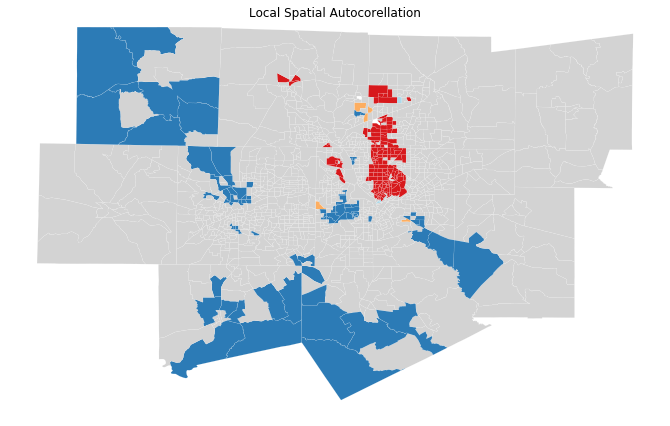

In [26]:
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler


fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(bottom=0.5)


y = merged['h_%cognitive'].values
w = Queen.from_dataframe(merged)

# Global moran's I
moran = Moran(y, w)
print('Global moran\'s I: '+str(moran.I))

# Local moran's I
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, merged,ax=ax, p=0.01,legend=False)


plt.suptitle('Local Spatial Autocorellation',fontsize=12)

plt.tight_layout()
plt.show()


### Linear Regression -- Saud 
#### merge centrality with housing and CBP varibales along with skills 
##### *centrality and other network analysis have been done on Gephi- https://gephi.org

In [109]:
dft1 = Adjusted_home_prices
dft2 = tx_est
dft3 = pd.read_csv('Data/all_year_eigenvector_centrality_tx.csv').rename(columns={'tract': 'TRACT'}).set_index('TRACT').sort_index()


In [110]:
indext = dft1.index

In [111]:
dft2 = dft2.loc[dft1.index]

In [112]:
dft3 = dft3.loc[dft1.index]

In [113]:
dft1=dft1.iloc[:,6:-3].stack().to_frame().reset_index()
dft1.columns=['TRACT', 'year', 'house_price']

dft2=dft2.iloc[:,6:].stack().to_frame().reset_index()
dft2.columns=['TRACT', 'year', 'est']
dft3 = dft3.reset_index()

# Adding Skills to the variables

In [11]:
skillst=pd.read_csv('Data/all_years_skills_tx.csv')

In [13]:
skillst.drop(['total','h_physical','h_cognitive','h_%physical','h_total'], axis=1, inplace=True)

In [15]:
skillst.columns=['TRACT', 'cognitive_fraction', 'year']
skillst.TRACT=skillst.TRACT.astype(str)
skillst.year=skillst.year.astype(str)

In [16]:
dft1.TRACT = dft1.TRACT.astype(str)
dft2.TRACT = dft2.TRACT.astype(str)
dft3.TRACT = dft3.TRACT.astype(str)

dft1.year = dft1.year.astype(str)
dft2.year = dft2.year.astype(str)
dft3.year = dft3.year.astype(str)

# Merging the variables together for each state

In [17]:
mer_tx = dft1.merge(skillst,on=['TRACT','year'])
mer_tx = dft2.merge(mer_tx,on=['TRACT','year'])
mer_tx = dft3.merge(mer_tx,on=['TRACT','year'])

In [19]:
# Adding city column
mer_tx['City'] = 'DL'

# Regression Analysis

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import normalize
from statsmodels.formula.api import ols


In [40]:
from sklearn.preprocessing import StandardScaler

# create an abs_scaler object
scaler = StandardScaler()

# calculate the maximum absolute value for scaling the data using the fit method
scaler.fit(mer)

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = scaler.transform(mer)

# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=mer.columns)

# visualize the data frame
df_scaled

,TRACT,eigenvector_centrality,eigenvector_centrality_low,eigenvector_centrality_high,cognitive_fraction,est,SF,DL,LA,year,house_price
0,-0.520762,-0.418174,-0.435021,-0.400396,1.918569,-0.771128,2.319814,-0.518122,-1.309539,-1.627424,4.970003
1,-0.520762,-0.395244,-0.472792,-0.378731,2.278019,-0.774316,2.319814,-0.518122,-1.309539,-1.410501,5.404642
2,-0.520762,-0.520667,-0.264707,-0.437881,1.788152,-0.772174,2.319814,-0.518122,-1.309539,1.626413,8.469756
3,-0.520762,-0.474073,-0.366668,-0.413551,2.031997,-0.767053,2.319814,-0.518122,-1.309539,-0.325889,5.634084
4,-0.520762,-0.459761,-0.335853,-0.415105,1.717961,-0.745887,2.319814,-0.518122,-1.309539,-0.759734,7.066544
...,...,...,...,...,...,...,...,...,...,...,...
99113,-0.514398,-0.116268,-0.280666,-0.250528,-2.392606,0.996522,-0.431069,-0.518122,0.763628,0.975645,-0.027406
99114,-0.514398,-0.045188,-0.050977,-0.193451,-2.599401,1.301319,-0.431069,-0.518122,0.763628,-0.542812,0.526808
99115,-0.514398,0.012212,-0.311231,-0.183260,-1.852132,1.005260,-0.431069,-0.518122,0.763628,1.626413,0.128895
99116,-0.514398,-0.138168,-0.325150,-0.257394,-2.609060,1.100821,-0.431069,-0.518122,0.763628,0.107956,-0.182313


In [61]:
#'''
from sklearn.preprocessing import MaxAbsScaler

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(mer)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# array([4.0e+05, 1.7e+01])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(mer)

# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=mer.columns)

# visualize the data frame
df_scaled
#'''
#pass

,TRACT,eigenvector_centrality,eigenvector_centrality_low,eigenvector_centrality_high,cognitive_fraction,est,SF,DL,LA,year,house_price
0,0.123747,0.003340,0.002383,0.001076,0.644679,0.115679,1.0,0.0,0.0,0.992563,0.451622
1,0.123747,0.003868,0.001363,0.001566,0.662348,0.115252,1.0,0.0,0.0,0.993059,0.483882
2,0.123747,0.000982,0.006979,0.000229,0.638268,0.115539,1.0,0.0,0.0,1.000000,0.711385
3,0.123747,0.002054,0.004227,0.000779,0.650255,0.116226,1.0,0.0,0.0,0.995538,0.500912
4,0.123747,0.002384,0.005059,0.000744,0.634818,0.119064,1.0,0.0,0.0,0.994546,0.607234
...,...,...,...,...,...,...,...,...,...,...,...
99113,0.126008,0.010288,0.006548,0.004464,0.432758,0.352688,0.0,0.0,1.0,0.998513,0.080699
99114,0.126008,0.011923,0.012746,0.005755,0.422592,0.393555,0.0,0.0,1.0,0.995042,0.121834
99115,0.126008,0.013244,0.005723,0.005985,0.459325,0.353859,0.0,0.0,1.0,1.000000,0.092300
99116,0.126008,0.009784,0.005347,0.004309,0.422118,0.366672,0.0,0.0,1.0,0.996529,0.069201


In [62]:
df_scaled1 = df_scaled

In [67]:
reg1  = ols("house_price ~ eigenvector_centrality", data = df_scaled1).fit() #cent
reg2  = ols("house_price ~ cognitive_fraction", data = df_scaled1).fit() #cog
reg3  = ols("house_price ~ est", data = df_scaled1).fit() #est
reg4  = ols("house_price ~ eigenvector_centrality + cognitive_fraction", data = df_scaled1).fit() #cent + cog
reg5  = ols("house_price ~ cognitive_fraction + est", data = df_scaled1).fit() #cog + est
reg6  = ols("house_price ~ eigenvector_centrality + cognitive_fraction + est", data = df_scaled1).fit() #cent + cog + est
reg7  = ols("house_price ~ DL", data = df_scaled1).fit() #city
reg8  = ols("house_price ~ year", data = df_scaled1).fit() #year
reg9  = ols("house_price ~ eigenvector_centrality + est + DL + year", data = df_scaled1).fit() #cent + est + city + year
reg10 = ols("house_price ~ eigenvector_centrality + cognitive_fraction + est + DL + year", data = df_scaled1).fit() #cent + cog + est + city + year


In [68]:
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML
stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10])

stargazer.significance_levels([0.1, 0.01, 0.001])
HTML(stargazer.render_html())


In [69]:
stargazer.render_latex()

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcccccccccccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{12}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{12-13}\n\\\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) & (10) & (11) & (12) \\\\\n\\hline \\\\[-1.8ex]\n DL & & & & & & & -0.049$^{***}$ & -0.098$^{***}$ & & & -0.357$^{***}$ & 0.083$^{***}$ \\\\\n  & & & & & & & (0.001) & (0.001) & & & (0.023) & (0.022) \\\\\n Intercept & 0.076$^{***}$ & -0.267$^{***}$ & 0.060$^{***}$ & -0.263$^{***}$ & -0.259$^{***}$ & -0.258$^{***}$ & 0.085$^{***}$ & 0.135$^{***}$ & 0.037$^{***}$ & -1.405$^{***}$ & -0.930$^{***}$ & 0.374$^{***}$ \\\\\n  & (0.000) & (0.002) & (0.000) & (0.002) & (0.002) & (0.002) & (0.000) & (0.001) & (0.000) & (0.103) & (0.069) & (0.066) \\\\\n LA & & & & & & & & -0.049$^{***}$ & 0.049$^{***}$ & & -0.313$^{***}$ & 0.130$^{***}$ \\\\\n  & & & & & & & & (0.001) & (0.001) & & (0.023) & (0.022) \\\\\n SF & & & & & & 